In [18]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [19]:
filename = 'dolphins.gml'
G_dolphins = nx.read_gml(filename)
B_dolphins = nx.modularity_matrix(G_dolphins)

In [20]:
B_dolphins.shape

(62, 62)

In [21]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [22]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.2)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.2)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.2)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        # reconstructed = nn.Dropout(p=0.2)(reconstructed)
        return encoder,reconstructed

In [23]:
learning_rate = 1e-3

In [24]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=32,in_layers=62)
model2=AE(hidden_layers=16,in_layers=32)
model3=AE(hidden_layers=8,in_layers=16)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=62, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=62, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=16, out_features=8, bias=True)
  (encoder_output_layer): Linear(in_features=8, out_features=8, bias=True)
  (decoder_hidden_layer): Linear(in_features=8, out_features=8, bias=True)
  (decoder_output_layer): Linear(in_features=8, out_features=16, bias=True)
)


In [25]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [26]:
B_dolphins=np.asarray(B_dolphins,dtype=np.float64)
inputs=torch.from_numpy(B_dolphins)
targets=torch.from_numpy(B_dolphins)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist1=train_model(100,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist2=train_model(300,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
# encoder,hist=train_model(200,train_dl,model3,optimizer3)
# train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder)
# print(encoder.detach().shape)

epoch : 1/100, recon loss = 0.08612645
epoch : 2/100, recon loss = 0.08442565
epoch : 3/100, recon loss = 0.08284849
epoch : 4/100, recon loss = 0.08138542
epoch : 5/100, recon loss = 0.08002617
epoch : 6/100, recon loss = 0.07876042
epoch : 7/100, recon loss = 0.07757812
epoch : 8/100, recon loss = 0.07646965
epoch : 9/100, recon loss = 0.07542600
epoch : 10/100, recon loss = 0.07443878
epoch : 11/100, recon loss = 0.07350029
epoch : 12/100, recon loss = 0.07260349
epoch : 13/100, recon loss = 0.07174208
epoch : 14/100, recon loss = 0.07091044
epoch : 15/100, recon loss = 0.07010358
epoch : 16/100, recon loss = 0.06931715
epoch : 17/100, recon loss = 0.06854736
epoch : 18/100, recon loss = 0.06779094
epoch : 19/100, recon loss = 0.06704516
epoch : 20/100, recon loss = 0.06630774
epoch : 21/100, recon loss = 0.06557685
epoch : 22/100, recon loss = 0.06485112
epoch : 23/100, recon loss = 0.06412962
epoch : 24/100, recon loss = 0.06341183
epoch : 25/100, recon loss = 0.06269769
epoch : 2

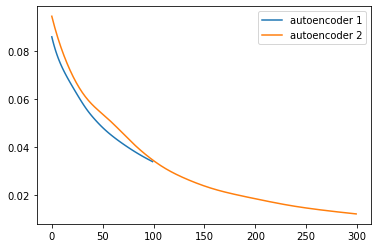

In [27]:
plt.plot(hist1,label='autoencoder 1')
plt.plot(hist2,label='autoencoder 2')
plt.legend()
plt.show()

In [28]:
B_dolphins_X=encoder.detach().numpy()

In [29]:
print(type(B_dolphins_X),B_dolphins_X)

<class 'numpy.ndarray'> [[ 3.22473258e-01 -1.64115563e-01 -1.49471583e-02 -4.57795769e-01
   3.86783257e-02  1.04887955e-01  2.88397521e-01  6.66543484e-01
  -3.28769237e-01 -2.72013724e-01 -2.79163241e-01 -9.59501937e-02
  -3.52953941e-01  1.25678748e-01  2.58904576e-01 -4.04479146e-01]
 [ 4.90992278e-01 -5.48346817e-01 -7.75979459e-02  9.91306081e-02
   2.16042101e-01  3.31448168e-01 -4.09318954e-01  6.13263547e-01
  -5.20005047e-01 -8.05503130e-02 -4.89809155e-01 -3.48236799e-01
   4.64960784e-02  2.63342261e-01  2.00599581e-01  7.93072805e-02]
 [ 3.09099883e-01  8.83723721e-02  8.05486292e-02 -1.93478152e-01
   2.26959407e-01  4.30543534e-02  2.63234049e-01  4.99668509e-01
  -2.60185838e-01 -1.92045569e-01 -4.40451860e-01 -1.07522756e-01
  -4.18205261e-01  1.38484508e-01  1.76308975e-01 -2.78384537e-01]
 [ 2.32123613e-01  1.40402734e-01 -2.40067199e-01 -2.50137359e-01
   7.35559687e-02 -1.88636228e-01 -3.68282706e-01  5.74346960e-01
  -1.71755552e-01  7.28688389e-02 -1.55776426e-01

In [30]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=605)
kmeans.fit(B_dolphins_X)
X_ae = kmeans.labels_
#---------------------------------------------------------|Ground Truth|-------
c_attributes = nx.get_node_attributes(G_dolphins,'value')
c_groups = []

for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[2 3 2 3 1 3 3 3 2 3 2 1 3 3 0 1 0 3 1 3 2 1 3 1 1 3 3 3 2 1 2 3 3 0 0 3 3
 0 0 3 3 3 2 0 3 1 3 2 3 3 1 1 0 3 3 1 3 3 3 1 3 3]
[1 0 1 2 3 0 0 0 2 0 1 3 2 0 2 3 2 0 3 0 2 3 0 3 3 0 0 0 1 3 1 0 0 2 2 3 2
 2 2 2 2 0 1 2 2 3 2 1 0 2 2 3 2 2 0 3 0 0 2 2 0 2]


0.5840649061253345

In [31]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_dolphins_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_dolphins,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.5931939860172735
Epoch:2 2 0.6156040679581002
Epoch:3 3 0.6923786888074088
Epoch:4 3 0.6923786888074088
Epoch:5 3 0.6923786888074088
Epoch:6 3 0.6923786888074088
Epoch:7 3 0.6923786888074088
Epoch:8 3 0.6923786888074088
Epoch:9 3 0.6923786888074088
Epoch:10 3 0.6923786888074088
Epoch:11 3 0.6923786888074088
Epoch:12 3 0.6923786888074088
Epoch:13 3 0.6923786888074088
Epoch:14 3 0.6923786888074088
Epoch:15 3 0.6923786888074088
Epoch:16 3 0.6923786888074088
Epoch:17 3 0.6923786888074088
Epoch:18 3 0.6923786888074088
Epoch:19 3 0.6923786888074088
Epoch:20 3 0.6923786888074088
Epoch:21 3 0.6923786888074088
Epoch:22 3 0.6923786888074088
Epoch:23 3 0.6923786888074088
Epoch:24 3 0.6923786888074088
Epoch:25 3 0.6923786888074088
Epoch:26 3 0.6923786888074088
Epoch:27 27 0.7608884918942155
Epoch:28 27 0.7608884918942155
Epoch:29 27 0.7608884918942155
Epoch:30 27 0.7608884918942155
Epoch:31 27 0.7608884918942155
Epoch:32 27 0.7608884918942155
Epoch:33 27 0.7608884918942155
Epoch:34 27 

KeyboardInterrupt: 

In [41]:
G=G_dolphins
list(G.nodes)[5]

'DN16'

In [42]:
G=G_dolphins
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=45)
kmeans.fit(B_dolphins_X)
X_ae = kmeans.labels_
labels_dict={0:[],1:[],2:[],3:[]}
for index,item in enumerate(X_ae):
    labels_dict[item].append(list(G.nodes)[index])
print(labels_dict)

{0: ['Cross', 'Five', 'Haecksel', 'Jonah', 'MN105', 'MN60', 'MN83', 'Patchback', 'Topless', 'TR99', 'Trigger', 'Vau'], 1: ['Beak', 'Bumper', 'Double', 'Fish', 'Kringel', 'Oscar', 'PL', 'SN96', 'TR77', 'Zap'], 2: ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN89', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig'], 3: ['CCL', 'Fork', 'Grin', 'Hook', 'Scabs', 'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN9', 'Stripes', 'Thumper', 'TR120', 'TR88', 'TSN103', 'TSN83', 'Whitetip', 'Zipfel']}


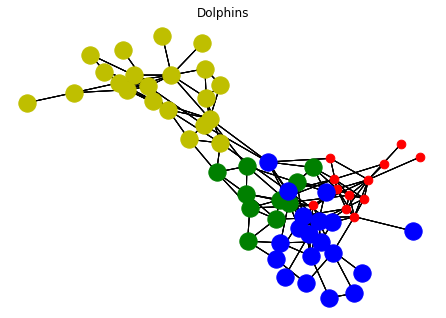

In [55]:
# filename = 'dolphins.gml'
# G_dolphins = nx.read_gml(filename)
# B_dolphins = nx.modularity_matrix(G_dolphins)
G=G_dolphins
pos=nx.spring_layout(G)
# print(pos)
# nx.draw_networkx_edges(G, pos=nx.spring_layout(G))
# nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[0],node_color='r',node_size=75)
# nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[1],node_color='g',node_size=75)
# nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[2],node_color='b',node_size=75)
# nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[3],node_color='y',node_size=75)
nx.draw(G,pos,nodelist=labels_dict[0],node_color='r',node_size=75)
nx.draw(G,pos,nodelist=labels_dict[1],node_color='g',node_size=75)
nx.draw(G,pos,nodelist=labels_dict[2],node_color='y',node_size=75)
nx.draw(G,pos,nodelist=labels_dict[3],node_color='b',node_size=75)

plt.title('Dolphins')
plt.show()